In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

%matplotlib inline

## Data Preprocessing

#### Import the raw dataset for Facebook Followers

In [3]:
df_raw = pd.read_csv('temp_datalab_records_social_facebook.csv', parse_dates=True)  # , squeeze=True
df_raw.head(2)  # the shape of the raw data framework is 3621391 rows * 7 columns
df_raw.shape

(1048575, 14)

#### This step includes removing columns we do not need, check missing values

In [4]:
# remove columns that don't contain useful information.
cols = ['dataset_id', 'has_added_app', 'date_added', 'date_updated', 'entity_id', 'cusip', 'isin']

# the leftover and important columns are [time, username, checkins, were_here_count, likes, talking_about_count, facebook_id]
df = df_raw.drop(cols, axis = 1)
df = df.dropna()  # drop NAN values
df.head(2)  # the shape of the data framework is 1016104 rows * 7 columns
df.shape

(1016104, 7)

#### Convert the type of the 'time' column 

In [5]:
df['time']= pd.to_datetime(df['time'])  # convert string 'time' into datetime format
# extract the date info from the time column, and store it into additional column called 'date'; and ignore the hours
df['date'] = [d.date() for d in df['time']]  

In [246]:
# look all the data in each column
for column in df.columns:
    print('Total types in {} column: {} '.format(column, df[column].value_counts().shape))
    print('Min. Value:', df[column].min(), 'Max. Value:', df[column].max())
    print('*-'*40)


Total types in time column: (605,) 
Min. Value: 2015-01-01 05:00:00+00:00 Max. Value: 2016-09-25 04:00:00+00:00
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Total types in username column: (3163,) 
Min. Value: 1011News Max. Value: zumiez
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Total types in checkins column: (46331,) 
Min. Value: 0 Max. Value: 3272742
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Total types in were_here_count column: (93575,) 
Min. Value: 0 Max. Value: 30847940
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Total types in likes column: (394857,) 
Min. Value: 1 Max. Value: 172901088
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-
Total types in talking_about_count column: (70419,) 
Min. Value: 0 Max. Value: 4652740
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*

# Q1: How users' experience correlated? (correlation matrix)

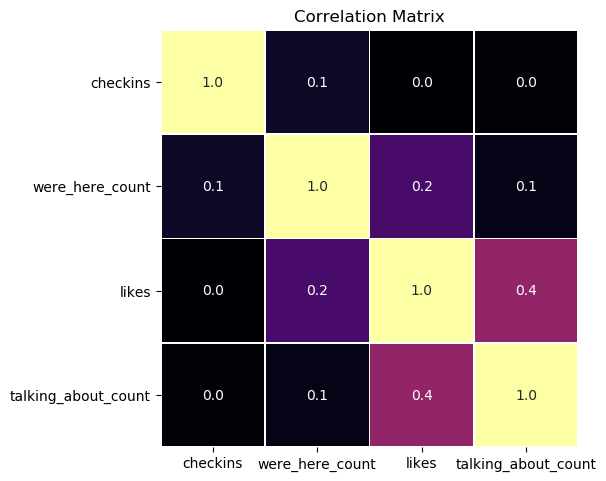

In [247]:
X = df[['checkins', 'were_here_count', 'likes', 'talking_about_count']]
corr_mat = X.corr()
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
label = ['checkins','were_here_count', 'likes', 'talking_about_count']
plot = sns.heatmap(corr_mat.T, square=True, annot=True, fmt='.1f', cbar=False, ax=ax, cmap='inferno', linewidths=.5,
                   xticklabels = label, yticklabels = label)
plot.set_yticklabels(plot.get_yticklabels(), rotation = 0)
ax.set_title('Correlation Matrix')
plt.tight_layout()

* Theoretically, 'checkins' and 'were_here_count' should have some relationships. Suprisingly, they are not well correlated. 

* Additionally, the strongest correlation is between 'likes' and 'talking_about_count'

# Q2: What's the top 20 most and least 'liked' companies 

* Define a general function to calculate the average value for each property we're interested

In [248]:
# define a function to calculate average properties

def calculate_average_properties(df, properties, num_comp):
    
    df_property = df.sort_values([properties], ascending = [False])
    list_company = list(set(df_property['username']))[:num_comp]
    
    # Defind a dictionary to store the average property value for each company
    average_for_company = {}
    for company in list_company:
        average_property_for_company = df[df['username'] == company][properties].mean(axis = 0, skipna = True)    
        average_for_company.update({company: average_property_for_company})

    # convert the dictionary into pandas framework, then re-order it with the descrending order of property value
    df_average_property_for_company = pd.DataFrame(list(average_for_company.items()), columns = ['Company', 'Average_' + properties])
    df_average_property_for_company = df_average_property_for_company.sort_values(['Average_' + properties], ascending = [False])

    return df_average_property_for_company


* Define a function to visualize the result for these four tags

In [257]:
# Define a function to visualize the most 'liked' or 'checkins' or 'were_here' or 'talking' company
def plot_most_prop_comp(df_avg_prop, props, top_num):

    df_avg_prop[:top_num].plot(kind = 'bar', x = 'Company', y = df_avg_prop.columns[1], fontsize = 16)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Companies', fontsize = 18)
    plt.title('Top {} Most {} Companies'.format(top_num, props), fontsize = 24)
    fig = plt.gcf(); fig.set_size_inches(16, 5)
    plt.show()   
    
# Define a function to visualize the least 'liked' or 'checkins' or 'were_here' or 'talking' company
def plot_least_prop_comp(df_avg_prop, props, top_num):

    df_avg_prop[-top_num:].plot(kind = 'bar', x = 'Company', y = df_avg_prop.columns[1], fontsize = 16)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Companies', fontsize = 18)
    plt.title('Top {} Least {} Companies'.format(top_num, props), fontsize = 24)
    fig = plt.gcf(); fig.set_size_inches(16, 5)
    plt.show() 

* Plot the top 20 most and least liked companies

In [ ]:
# Calculate the average 'likes' value for each company, and output the data framework in the ascending order
df_avg_likes = calculate_average_properties(df, 'likes', num_comp = 3163)

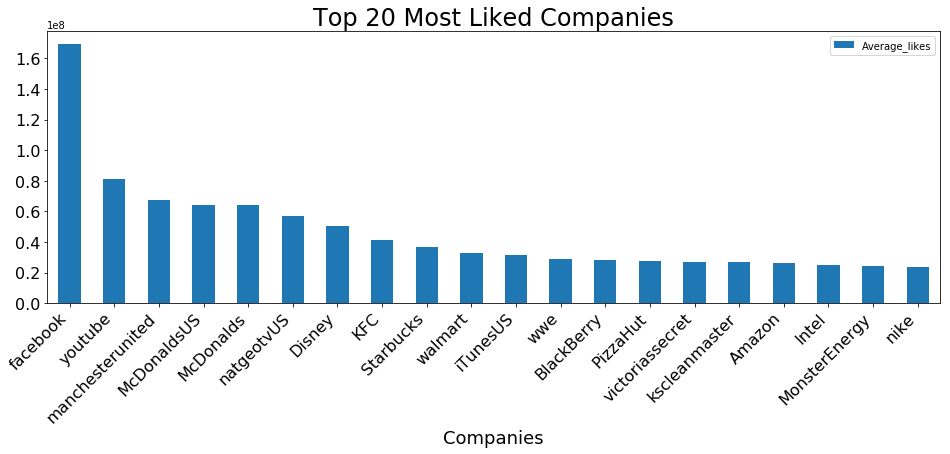

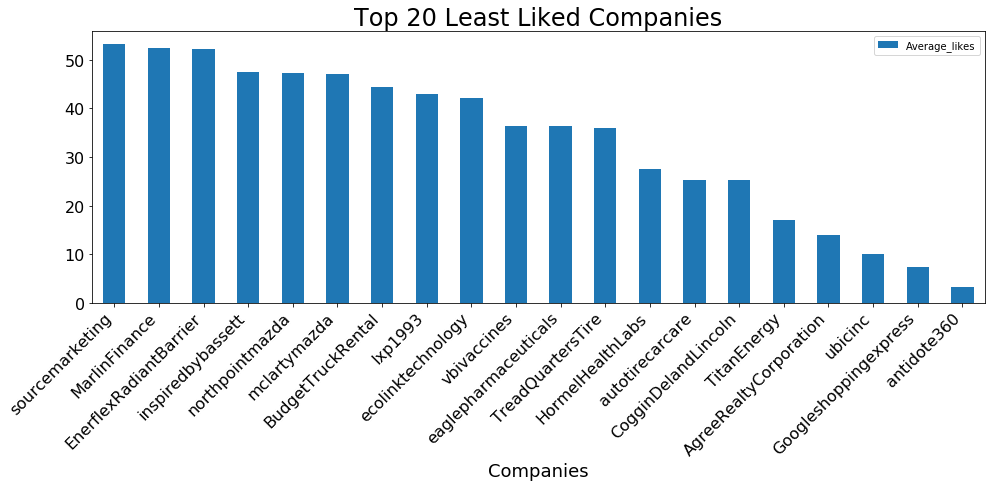

In [258]:
plot_most_prop_comp(df_avg_likes, props = 'Liked', top_num = 20)
plot_least_prop_comp(df_avg_likes, props = 'Liked', top_num = 20)

* Comments on the top 20 most and least liked companies:

* The top 2 liked companies are social media: FB and Youtube. The more the company engaged with our daily life, the more it will be liked. Then it's the football club: manchesterunited. 

* Future Work: Multiple types of companies are listed in the top 20, for example, fast-food companies, retail corporation, e-commerce high-tech companies. Each type of the companies can be further selected and analyzed. The same analysis can be done for each year to see the popularity change for companies.  

* For the top 20 least liked companies, it's also interesting to understand what happended to them.

# Q3: What's the top 20 most 'check_in' companies ?

In [260]:
# Calculate the average 'checkins' value for each company
df_avg_checkin = calculate_average_properties(df, 'checkins', num_comp = 3163)

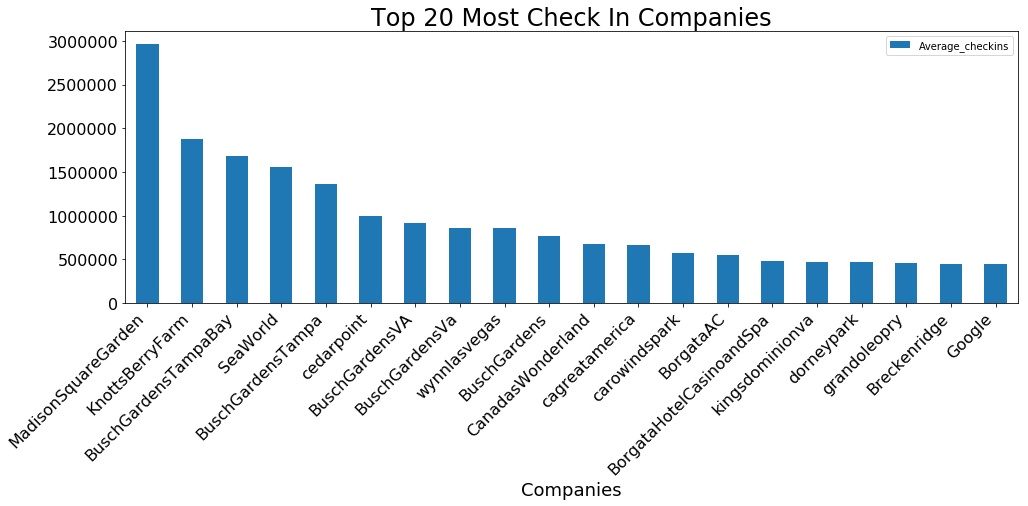

In [261]:
plot_most_prop_comp(df_avg_checkin, props = 'Check In', top_num = 20)  # checkin min = 0

* Most checked-in companies are place of interests, for examples, famous theme parks Busch Gardens.

# Q4: What's the top 20 most 'were_here_count' companies ?

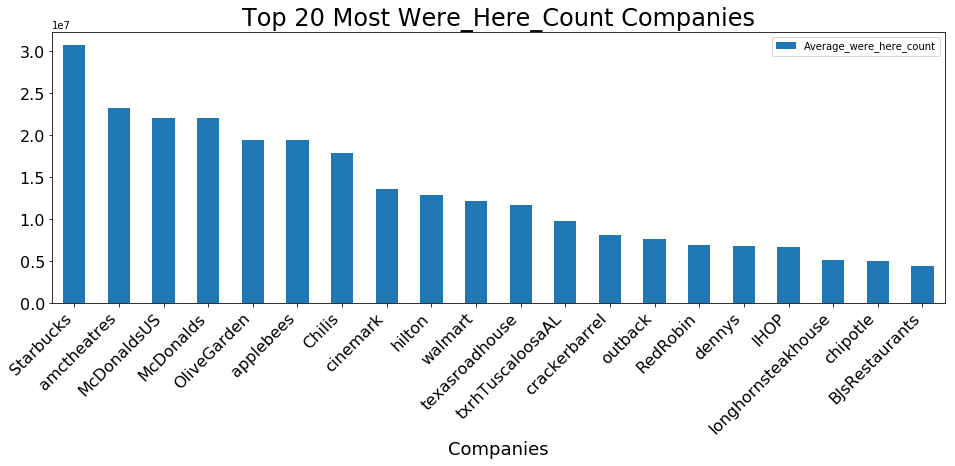

In [262]:
# Calculate the average 'checkins' value for each company
df_avg_werehere = calculate_average_properties(df, 'were_here_count', num_comp = 3163)
plot_most_prop_comp(df_avg_werehere, props = 'Were_Here_Count', top_num = 20)
# plot_least_prop_comp(df_avg_checkin, props = 'were_here_count', top_num = 6)  # were_here_count min. = 0

* Most were_here_count companies belong to fast-food restaurants. Among the top 10, it has 6 fast-food companies, 2 theaters, 1 hotel, and 1 retail company. 16 companies are related with food among these top 20 companies, which shows restaurants are the winners in attracting customers to physical locations, especially steakhouse.

# Q5: What's the top 20 most and least 'talking_about_count' companies ?

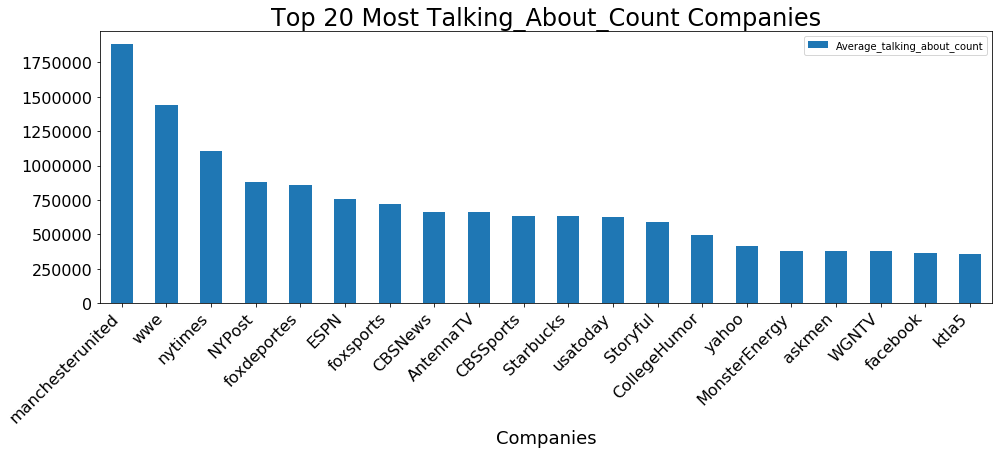

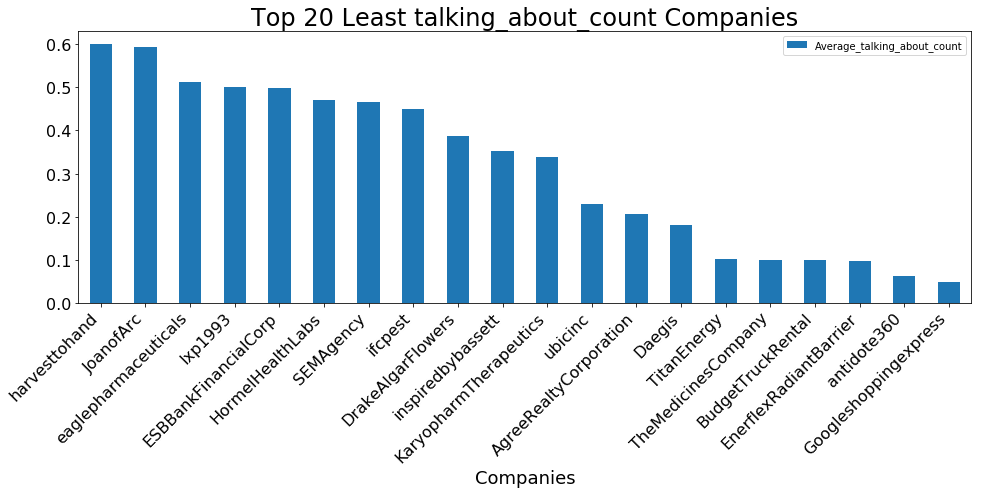

In [263]:
# Calculate the average 'checkins' value for each company
df_avg_talkingabout = calculate_average_properties(df, 'talking_about_count', num_comp = 3163)
plot_most_prop_comp(df_avg_talkingabout, props = 'Talking_About_Count', top_num = 20)
plot_least_prop_comp(df_avg_talkingabout, props = 'talking_about_count', top_num = 20)


* Talking about means a user has either liked, mentioned, photo tagged, commented on or shared a post. We found users are very enthusiastic about the ManchesterUnited football club, sports, newspaper information.

## Q6: How the FB followers experience change with the time for most liked companies?
* Five Companies selected from top 20 most liked Companies

In [21]:
df_raw_3m = pd.read_csv('3m_temp_datalab_records_social_facebook.csv', parse_dates=True)  # , squeeze=True
cols = ['dataset_id', 'has_added_app', 'date_added', 'date_updated', 'entity_id', 'cusip', 'isin']
df3m = df_raw_3m.drop(cols, axis = 1).dropna()
df3m['time']= pd.to_datetime(df3m['time'])  # convert string 'time' into datetime format
df3m['date'] = [d.date() for d in df3m['time']] 


In [20]:
print(df3m.shape)

(3500462, 8)


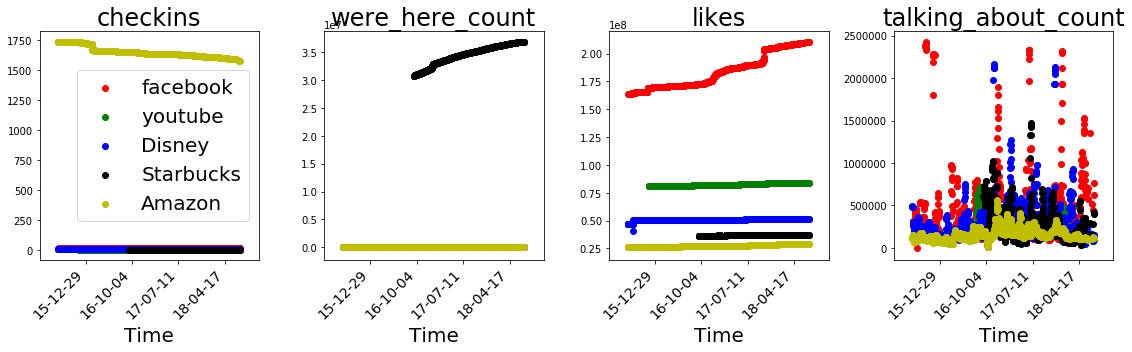

In [43]:
# we pick five companies which have largest dataset_id available
# Q1: plot the columns_properties vs time to visualize how the properties change with time

fig, axes = plt.subplots(1,4, figsize = (16,5))

top_five_company = ['facebook', 'youtube', 'Disney', 'Starbucks', 'Amazon']
# top_five_company = ['facebook', 'youtube', 'manchesterunited', 'McDonalds', 'natgeotvUS']
colors_five =['r','g','blue','black','y']
colors = dict(zip(top_five_company, colors_five))
labels = dict(zip(top_five_company, top_five_company))

# top_five_company = ['facebook', 'youtube', 'Disney', 'Starbucks', 'Amazon']
# colors = {'facebook':'r', 'youtube':'g', 'Disney':'blue', 'Starbucks':'black', 'Amazon':'y'}
# labels = {'facebook':'Facebook', 'youtube':'Youtube', 'Disney':'Disney', 'Starbucks':'Starbucks', 'Amazon':'Amazon'}
# columns_des = ['checkins', 'were_here_count', 'likes', 'talking_about_count']

# five colors show different companies
for j, column in enumerate(columns_des):
    for i, company in enumerate(top_five_company):
        subdf = df3m[df3m['username'] == company]        
        axes[j].scatter(subdf['date'], subdf[column], color = colors[company],label = labels[company])
    
    if column == 'checkins':
        axes[j].legend(loc = 'best', prop={'size': 20})
            
    
    axes[j].set_title(column, fontsize = 24)
    axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation = 45, ha = 'right', fontsize = 14)
#     axes[j].set_yticklabels(fontsize = 12)

    axes[j].xaxis.set_major_locator(mdates.WeekdayLocator(interval= 40))
    axes[j].xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))

    axes[j].set_xlabel('Time', fontsize = 20)
    
fig.tight_layout()
plt.show()

## Q7: How the user' experience change with the time 5 food restaurants?
* Five food Companies selected from top 20 most were_here_count Companies

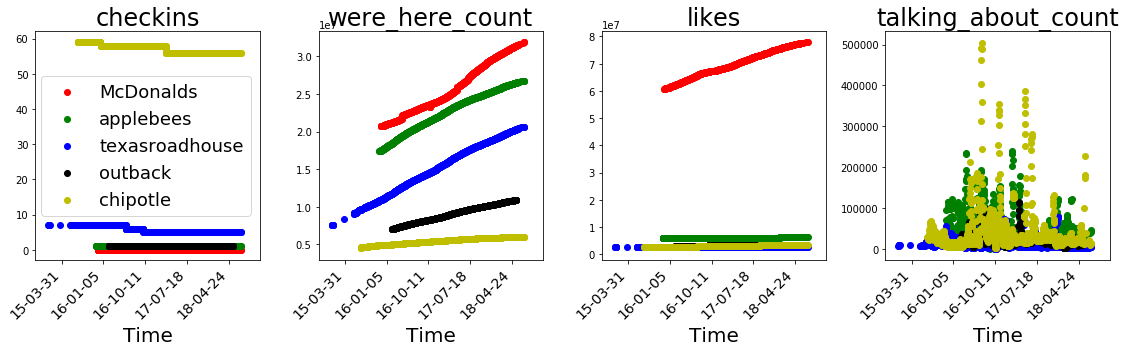

In [47]:
# we pick five companies which have largest dataset_id available
# Q1: plot the columns_properties vs time to visualize how the properties change with time

fig, axes = plt.subplots(1,4, figsize = (16,5))

top_five_company = ['McDonalds', 'applebees', 'texasroadhouse', 'outback', 'chipotle']
colors_five =['r','g','blue','black','y']
colors = dict(zip(top_five_company, colors_five))
labels = dict(zip(top_five_company, top_five_company))

columns_des = ['checkins', 'were_here_count', 'likes', 'talking_about_count']

# five colors show different companies
for j, column in enumerate(columns_des):
    for i, company in enumerate(top_five_company):
        subdf = df3m[df3m['username'] == company]        
        axes[j].scatter(subdf['date'], subdf[column], color = colors[company],label = labels[company])
    
    if column == 'checkins':
        axes[j].legend(loc = 'best', prop={'size': 18})
            
    
    axes[j].set_title(column, fontsize = 24)
    axes[j].set_xticklabels(axes[j].get_xticklabels(), rotation = 45, ha = 'right', fontsize = 14)
    axes[j].xaxis.set_major_locator(mdates.WeekdayLocator(interval= 40))
    axes[j].xaxis.set_major_formatter(DateFormatter("%y-%m-%d"))

    axes[j].set_xlabel('Time', fontsize = 20)
    
fig.tight_layout()
plt.show()